In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
from torch import nn
import torch.nn.functional as F
import torchzero as tz
from visualbench import FunctionDescent, test_functions

# 7. Non-linear least squares
### 7.1 Gauss-Newton
A non-linear least squares problem is a problem of the form:
$$
\underset{x}{\operatorname{argmin}} \sum_{i=1}^{m} f(x)_i^2
$$
Here instead of outputing a single value, the objective function $f$ outputs $m$ values, and the goal is to minimize the sum of their squares. Of course it is possible to simply compute sum of their squares and use any normal optimization method to minimize that scalar value. But we can minimize this problem very efficiently using the **Gauss-Newton** method which uses those $m$ values and their jacobian to estimate the hessian.

Suppose we have a function of $n$ parameters that outputs a vector $r \in \mathbb{R}^m$, this vector is called vector of **residuals**, and the goal is for all residuals to be as small as possible. Gauss-Newton uses the Jacobian matrix $J \in \mathbb{R}^{m \times n}$ of $r$ with respect to parameters $x$. It can be calculated by stacking gradients of each value $r_1, r_2, ..., r_m$ as rows of $J$. Then the Gauss-Newton step is:
$$
x_{t+1} \leftarrow x_t - \eta (J^T J)^{\dagger} J^T r
$$

Here $\eta$ is a step size which can be fixed or determined via a [line search](<../8. Line search>). $(J^T J)^{\dagger}$ means Moore-Penrose inverse of $J^T J$ which is used because this matrix is low rank and has no inverse. Gauss-Newton can also be used with [trust region](<../9. Trust region>).

Same as with [Newton's method](<../4. Second order methods>), in practice the Gauss-Newton step is computed as a linear least-squares solution to a linear system because that is faster to compute:
$$
\text{lstsq:}\\\\ (J^T J)v_t = J^T r
$$
$$
x_{t+1} \leftarrow x_t - v_t
$$


For visualization we use Rosenbrock's function. The standard Rosenbrock's function is:
$$
f(x,y) = (1 - x)^2 + 100 * (y - x^2)^2
$$

You can easily see that this function is a sum of squares of two terms: $(1 - x)$ and $(y - x^2)$, and second term is multiplied by 100. So we can rewrite this function to return a vector of two residuals and solve it with Gauss-Newton:
$$
f(x, y) = [(1 - x), 100 * (y - x^2)]
$$

In torchzero to use `GaussNewton`, the closure must return a vector of residuals. The closure should not perform a backward pass, it is handled by `GaussNewton` module. The gradients are calculated in a batch which is usually much faster that a for loop.

finished in 0.2s., reached loss = 5.66e-06                                      
finished in 0.0s., reached loss = 0                                      
finished in 0.5s., reached loss = 2.4e-12                                      


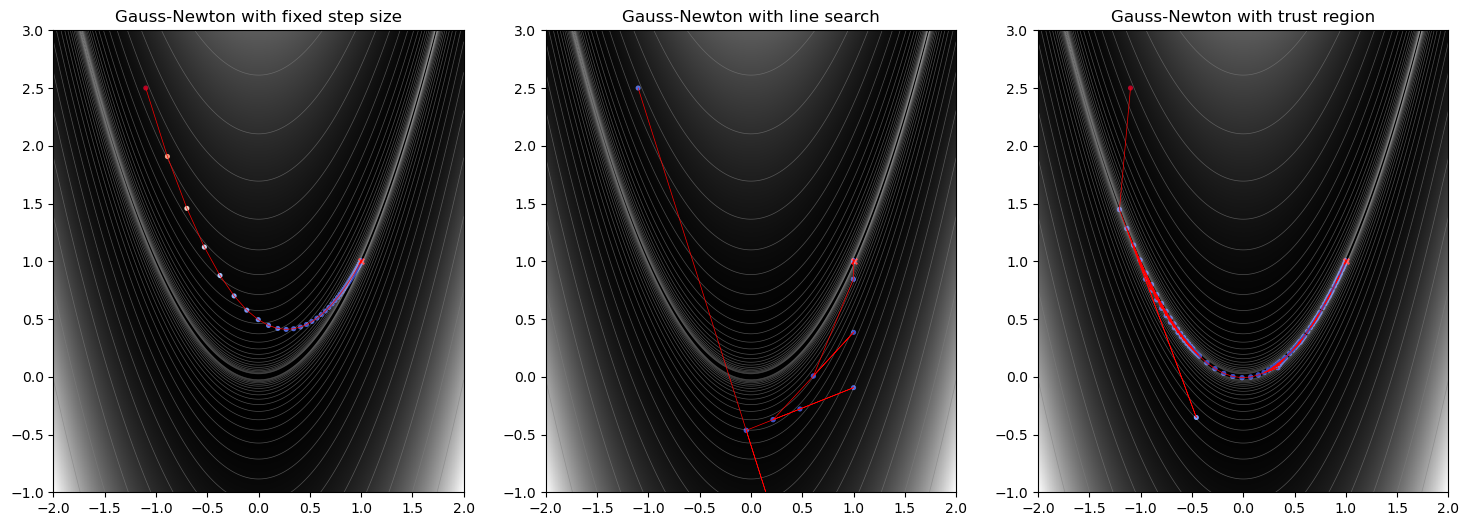

In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))
ax = np.ravel(ax)

func = FunctionDescent('rosen_mo').set_multiobjective()
optimizer = tz.Modular(func.parameters(), tz.m.GaussNewton(), tz.m.LR(1e-1))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("Gauss-Newton with fixed step size")

func = FunctionDescent('rosen_mo').set_multiobjective()
optimizer = tz.Modular(func.parameters(), tz.m.GaussNewton(), tz.m.Backtracking())
func.run(optimizer, max_steps=10)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("Gauss-Newton with line search")

func = FunctionDescent('rosen_mo').set_multiobjective()
optimizer = tz.Modular(func.parameters(), tz.m.LevenbergMarquardt(tz.m.GaussNewton()))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("Gauss-Newton with trust region")


plt.show()

### 7.2 Levenberg-Marquardt
Gauss-Newton with Levenberg-Marquardt trust region (see [9. Trust region](<../9. Trust region>)) is commonly called Levenberg-Marquardt method. Levenberg-Marquardt adds scaled identity matrix to hessian or hessian approximation. When used with Gauss-Newton approximation, identity matrix is often replaced with a diagonal matrix with gradient in the diagonal.

In torchzero this is determined by `y` argument. If it is 0, scaled identity is used, if it is 1, gradient is used. Values between 0 and 1 interpolate.

finished in 0.5s., reached loss = 2.4e-12                                      
finished in 0.3s., reached loss = 3.2e-14                                      
finished in 0.3s., reached loss = 3.55e-11                                      


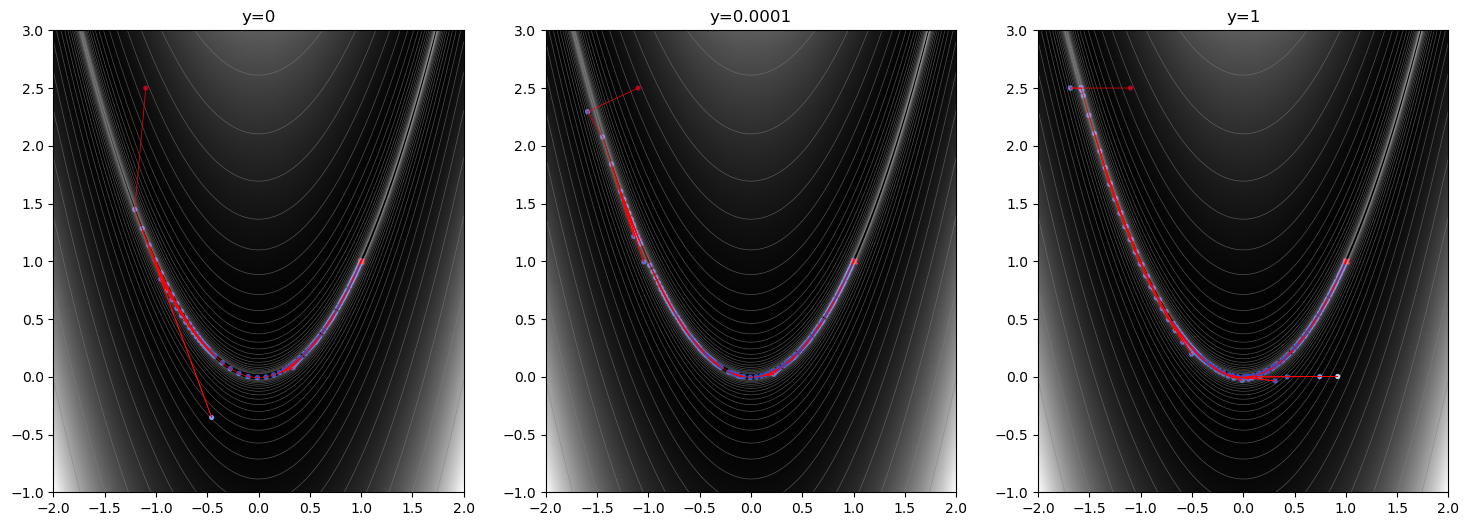

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))
ax = np.ravel(ax)

func = FunctionDescent('rosen_mo').set_multiobjective()
optimizer = tz.Modular(func.parameters(), tz.m.LevenbergMarquardt(tz.m.GaussNewton(), y=0))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("y=0")

func = FunctionDescent('rosen_mo').set_multiobjective()
optimizer = tz.Modular(func.parameters(), tz.m.LevenbergMarquardt(tz.m.GaussNewton(), y=0.0001))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("y=0.0001")

func = FunctionDescent('rosen_mo').set_multiobjective()
optimizer = tz.Modular(func.parameters(), tz.m.LevenbergMarquardt(tz.m.GaussNewton(), y=1))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("y=1")

plt.show()

### 7.3 Memory-efficient GN

Gauss-Newton requires at least $n^2$ memory to store $J^T J$. However $(J^T J)v_t = J^T r$ can be solved with an iterative solver which only uses matrix-vector products and never forms full $J^T J$, such as conjugate gradient, similarly to NewtonCG. Since $(J^T J)$ is a low rank matrix, CG will be slow on it, but truncating it via `TrustCG` seems to work well.

In [29]:
DIM = 100_000
device = 'cuda' if torch.cuda.is_available() else None

def quartic(x:torch.Tensor, y):
    x = x+y
    vals = x[1:].pow(2).mean(), x[:-1].sum().pow(2), x[::2].pow(2).mean(), x[1::2].sum().pow(2)
    return torch.stack(vals)

X = torch.randn(DIM, requires_grad=True, device=device)
y = torch.randn(DIM, device=device)

opt = tz.Modular([X], tz.m.TrustCG(tz.m.GaussNewton()))

def closure(backward=True):
    loss = quartic(X, y)
    return loss

for i in range(101):
    residuals = opt.step(closure).detach().cpu()
    if i % 10 == 0: print(f'{i}: {residuals = }')

0: residuals = tensor([1.9872e+00, 4.5396e+04, 1.9815e+00, 2.0207e+05])
10: residuals = tensor([2.5785e+01, 3.5142e-03, 9.0268e-01, 1.8182e-01])
20: residuals = tensor([0.2067, 0.0226, 0.1486, 0.0044])
30: residuals = tensor([5.7811e-05, 1.5097e-06, 3.1676e-05, 3.7373e-07])
40: residuals = tensor([1.5198e-05, 1.5363e-07, 6.8468e-06, 3.9018e-08])
50: residuals = tensor([1.5198e-05, 4.6852e-08, 6.8466e-06, 9.5175e-09])
60: residuals = tensor([1.5197e-05, 2.7983e-08, 6.8464e-06, 3.9187e-09])
70: residuals = tensor([1.5197e-05, 1.4034e-08, 6.8462e-06, 4.1130e-10])
80: residuals = tensor([1.5197e-05, 1.9402e-09, 6.8460e-06, 2.4563e-09])
90: residuals = tensor([1.5197e-05, 1.8622e-09, 6.8458e-06, 2.0805e-09])
100: residuals = tensor([1.5197e-05, 1.8213e-09, 6.8456e-06, 1.7972e-09])
